In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import KNNImputer, IterativeImputer  # Now import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import BaggingClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import time

In [47]:
# Set seed untuk reproduksibilitas
np.random.seed(42)

# --- Membuat Dataset Dummy "Sangat Hancur" ---
n = 10000
feature1 = np.concatenate([np.random.exponential(scale=100, size=int(n * 0.85)), np.random.uniform(1000, 20000, int(n * 0.15))])
feature2 = np.concatenate([np.random.uniform(0, 500, int(n * 0.80)), np.random.uniform(5000, 10000, int(n * 0.20))])
feature2[np.random.choice(n, int(n * 0.25), replace=False)] = np.nan
feature3 = np.random.choice(['A', 'B', 'C', 'D', 'E'], n)
feature4 = np.concatenate([np.random.normal(50, 10, int(n * 0.90)), np.random.uniform(500, 1500, int(n * 0.10))])
feature4[np.random.choice(n, int(n * 0.20), replace=False)] = np.nan
target = np.random.choice([0, 1], n, p=[0.9, 0.1])

data = pd.DataFrame({
    'Feature1': feature1,
    'Feature2': feature2,
    'Feature3': feature3,
    'Feature4': feature4,
    'Target': target
})


=== Exploratory Data Analysis (EDA) ===
Analisis awal untuk memahami karakteristik dataset dan kebutuhan pra-pemrosesan untuk KNN.

1. Skala dan Rentang Fitur Numerik:
Statistik deskriptif untuk memeriksa rentang dan distribusi awal fitur numerik:
           Feature1     Feature2     Feature4
count  10000.000000  7500.000000  8000.000000
mean    1639.721759  1674.797592   142.781237
std     4211.120160  2966.793328   295.081890
min        0.001163     0.078872     5.343961
25%       33.651771   158.543597    43.767939
50%       86.875845   310.377785    51.105661
75%      211.118481   466.813388    59.535007
max    19990.598604  9999.357191  1499.672307
- Alasan: KNN sensitif terhadap skala fitur; perbedaan skala besar dapat mendominasi perhitungan jarak.


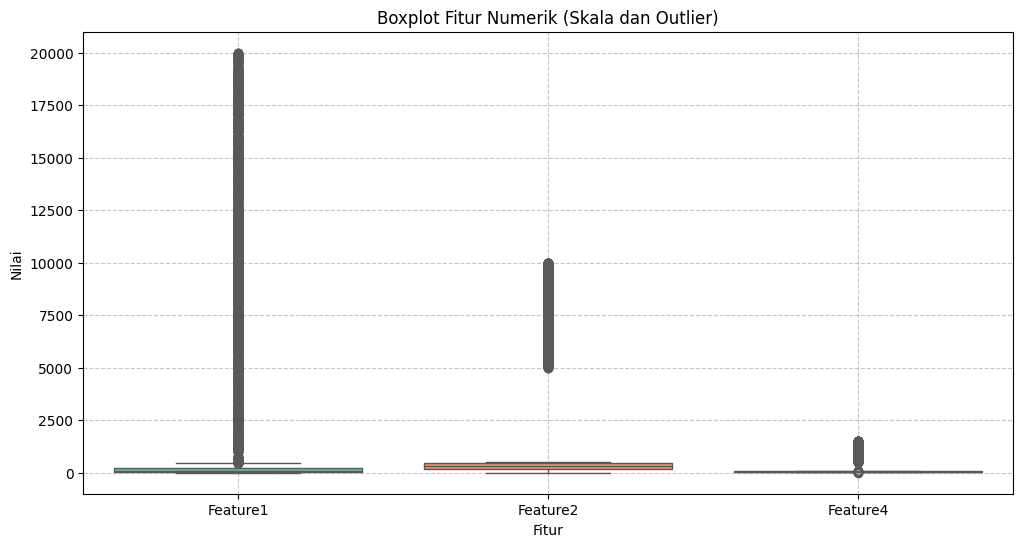

In [48]:
# --- Langkah 2: Exploratory Data Analysis (EDA) ---
print("\n=== Exploratory Data Analysis (EDA) ===")
print("Analisis awal untuk memahami karakteristik dataset dan kebutuhan pra-pemrosesan untuk KNN.")

# 1. Skala dan Rentang Fitur
print("\n1. Skala dan Rentang Fitur Numerik:")
print("Statistik deskriptif untuk memeriksa rentang dan distribusi awal fitur numerik:")
print(data[['Feature1', 'Feature2', 'Feature4']].describe())
print("- Alasan: KNN sensitif terhadap skala fitur; perbedaan skala besar dapat mendominasi perhitungan jarak.")
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Feature1', 'Feature2', 'Feature4']], palette='Set2')
plt.title("Boxplot Fitur Numerik (Skala dan Outlier)")
plt.xlabel("Fitur")
plt.ylabel("Nilai")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


2. Distribusi Fitur dan Skewness:
Memeriksa distribusi dan kemiringan (skewness) untuk setiap fitur numerik:
- Feature1: Skewness = 2.80
  Interpretasi: Sangat miring positif
- Feature2: Skewness = 1.71
  Interpretasi: Sangat miring positif
- Feature4: Skewness = 3.14
  Interpretasi: Sangat miring positif
- Alasan: Skewness tinggi dapat memengaruhi perhitungan jarak KNN karena distribusi tidak merata.


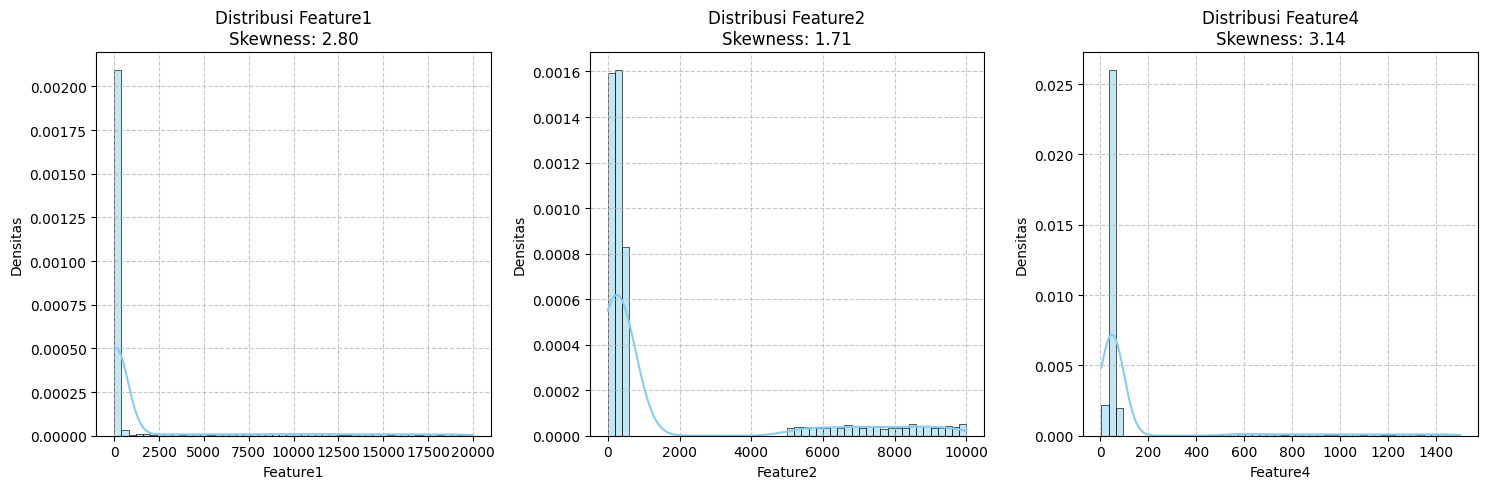

In [49]:
# 2. Distribusi Fitur dan Skewness
print("\n2. Distribusi Fitur dan Skewness:")
print("Memeriksa distribusi dan kemiringan (skewness) untuk setiap fitur numerik:")
for col in ['Feature1', 'Feature2', 'Feature4']:
    skewness = skew(data[col].dropna())
    print(f"- {col}: Skewness = {skewness:.2f}")
    print(f"  Interpretasi: {'Sangat miring positif' if skewness > 1 else 'Miring negatif' if skewness < -1 else 'Cukup simetris'}")
print("- Alasan: Skewness tinggi dapat memengaruhi perhitungan jarak KNN karena distribusi tidak merata.")
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Feature1', 'Feature2', 'Feature4'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col].dropna(), kde=True, bins=50, color='skyblue', stat='density')
    plt.title(f"Distribusi {col}\nSkewness: {skew(data[col].dropna()):.2f}")
    plt.xlabel(col)
    plt.ylabel("Densitas")
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
# 3. Deteksi Outlier dengan IQR
print("\n3. Deteksi Outlier (Metode IQR):")
print("Menghitung jumlah outlier untuk setiap fitur numerik menggunakan metode Interquartile Range (IQR):")
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers), lower_bound, upper_bound

for col in ['Feature1', 'Feature2', 'Feature4']:
    n_outliers, lower, upper = detect_outliers_iqr(data, col)
    print(f"- {col}: {n_outliers} outlier (Batas: {lower:.2f} - {upper:.2f})")
print("- Alasan: Outlier di semua fitur dapat mendistorsi perhitungan jarak KNN, memerlukan penanganan khusus.")


3. Deteksi Outlier (Metode IQR):
Menghitung jumlah outlier untuk setiap fitur numerik menggunakan metode Interquartile Range (IQR):
- Feature1: 1562 outlier (Batas: -232.55 - 477.32)
- Feature2: 1461 outlier (Batas: -303.86 - 929.22)
- Feature4: 815 outlier (Batas: 20.12 - 83.19)
- Alasan: Outlier di semua fitur dapat mendistorsi perhitungan jarak KNN, memerlukan penanganan khusus.



4. Missing Values:
Persentase nilai hilang untuk setiap kolom:
Feature1     0.0
Feature2    25.0
Feature3     0.0
Feature4    20.0
Target       0.0
dtype: float64
- Alasan: KNN tidak dapat memproses nilai hilang (NaN), sehingga imputasi diperlukan.


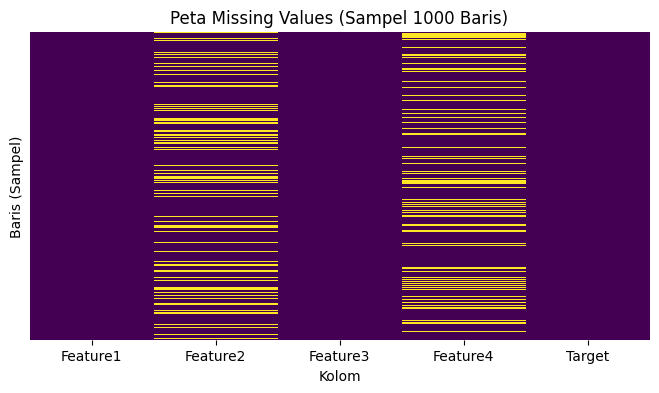

In [51]:
# 4. Missing Values
print("\n4. Missing Values:")
print("Persentase nilai hilang untuk setiap kolom:")
missing_percentage = data.isna().mean() * 100
print(missing_percentage)
print("- Alasan: KNN tidak dapat memproses nilai hilang (NaN), sehingga imputasi diperlukan.")
plt.figure(figsize=(8, 4))
sns.heatmap(data.isna().sample(1000), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Peta Missing Values (Sampel 1000 Baris)")
plt.xlabel("Kolom")
plt.ylabel("Baris (Sampel)")
plt.show()


5. Distribusi Kelas Target:
Persentase distribusi kelas target untuk mengevaluasi ketidakseimbangan:
Target
0    89.64
1    10.36
Name: proportion, dtype: float64
- Alasan: Ketidakseimbangan kelas ekstrem dapat menyebabkan bias pada KNN, memerlukan teknik seperti oversampling.


<ipython-input-52-a937e051c25a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=data, palette='Set1')


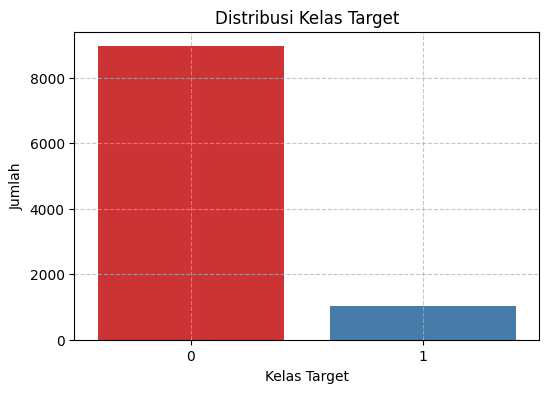

In [52]:
# 5. Distribusi Target
print("\n5. Distribusi Kelas Target:")
print("Persentase distribusi kelas target untuk mengevaluasi ketidakseimbangan:")
target_dist = data['Target'].value_counts(normalize=True) * 100
print(target_dist)
print("- Alasan: Ketidakseimbangan kelas ekstrem dapat menyebabkan bias pada KNN, memerlukan teknik seperti oversampling.")
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data, palette='Set1')
plt.title("Distribusi Kelas Target")
plt.xlabel("Kelas Target")
plt.ylabel("Jumlah")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


6. Pairplot (Sampel 1000 Baris):
Visualisasi hubungan antar fitur numerik dan distribusi berdasarkan kelas target:


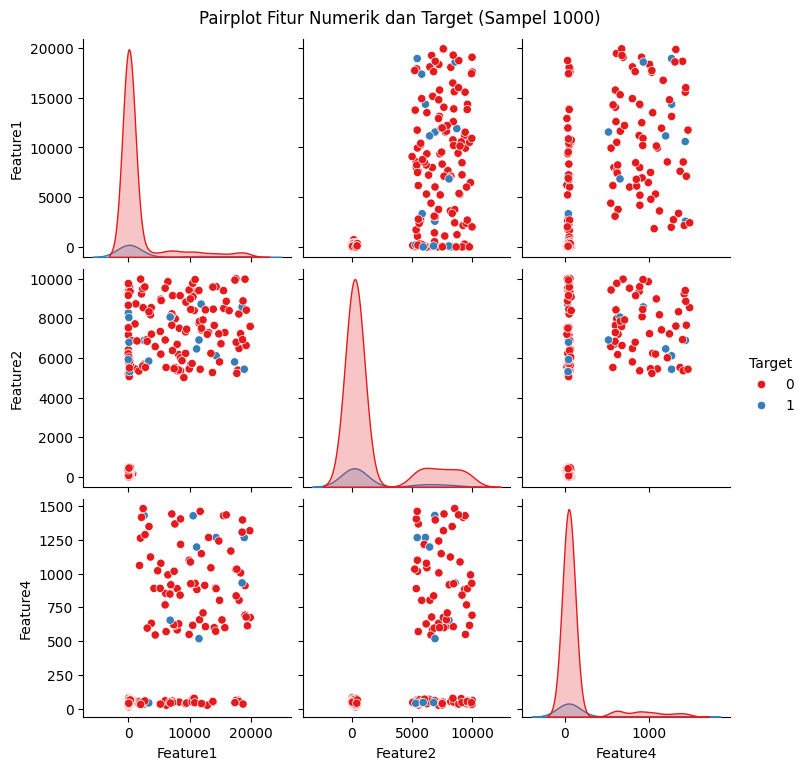

- Alasan: Pairplot menunjukkan overlap kelas, noise, dan potensi hubungan non-linier yang perlu diperhatikan.


In [53]:
# 6. Pairplot untuk Hubungan Antar Fitur
print("\n6. Pairplot (Sampel 1000 Baris):")
print("Visualisasi hubungan antar fitur numerik dan distribusi berdasarkan kelas target:")
sns.pairplot(data[['Feature1', 'Feature2', 'Feature4', 'Target']].sample(1000), hue='Target', diag_kind='kde', palette='Set1')
plt.suptitle("Pairplot Fitur Numerik dan Target (Sampel 1000)", y=1.02)
plt.show()
print("- Alasan: Pairplot menunjukkan overlap kelas, noise, dan potensi hubungan non-linier yang perlu diperhatikan.")


=== Pra-Pemrosesan Data ===
Langkah-langkah untuk mempersiapkan data agar sesuai dengan kebutuhan KNN.

1. Penanganan Outlier (Isolation Forest + Log Transformasi):
Sebelum penanganan outlier:
           Feature1     Feature2     Feature4
count  10000.000000  7500.000000  8000.000000
mean    1639.721759  1674.797592   142.781237
std     4211.120160  2966.793328   295.081890
min        0.001163     0.078872     5.343961
25%       33.651771   158.543597    43.767939
50%       86.875845   310.377785    51.105661
75%      211.118481   466.813388    59.535007
max    19990.598604  9999.357191  1499.672307
Jumlah baris awal: 10000
Jumlah baris setelah dropna: 5971
Jumlah baris setelah Isolation Forest: 5075
Sesudah penanganan outlier dan transformasi:
          Feature1     Feature2     Feature4
count  5075.000000  5075.000000  5075.000000
mean      4.055641     5.416717    49.715989
std       1.174797     1.221729    10.052316
min       0.001163     0.075916    15.466459
25%       3.385966 

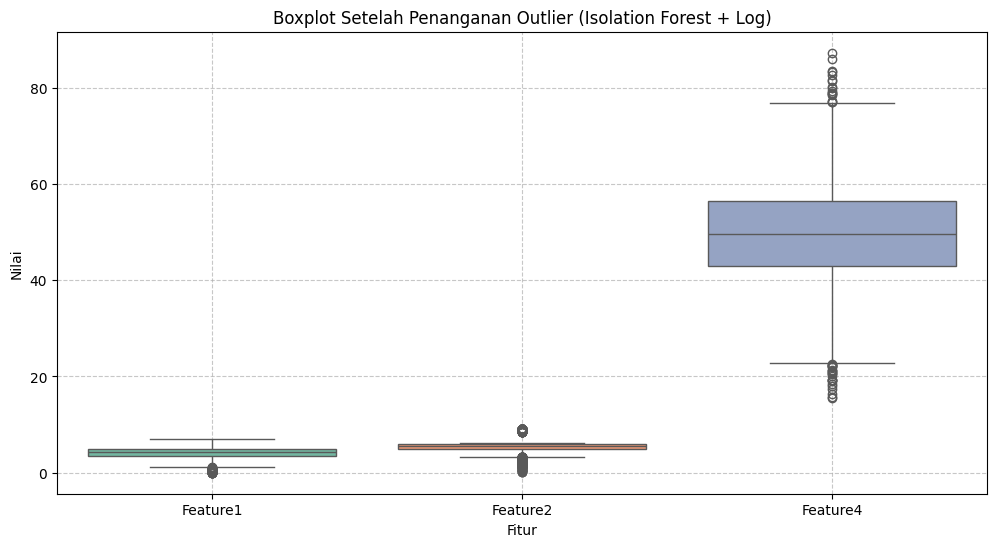

- Alasan: Isolation Forest menghapus outlier multi-dimensi; Log Transformasi mengurangi skewness pada Feature1 dan Feature2.


In [54]:
# --- Langkah 3: Pra-Pemrosesan Data ---
print("\n=== Pra-Pemrosesan Data ===")
print("Langkah-langkah untuk mempersiapkan data agar sesuai dengan kebutuhan KNN.")

# 1. Penanganan Outlier dengan Isolation Forest dan Log Transformasi
print("\n1. Penanganan Outlier (Isolation Forest + Log Transformasi):")
print("Sebelum penanganan outlier:")
print(data[['Feature1', 'Feature2', 'Feature4']].describe())
data_clean = data.copy()
print(f"Jumlah baris awal: {len(data_clean)}")

# Terapkan Isolation Forest pada data numerik tanpa missing values
numeric_data = data_clean[['Feature1', 'Feature2', 'Feature4']].dropna()
print(f"Jumlah baris setelah dropna: {len(numeric_data)}")
iso_forest = IsolationForest(contamination=0.15, random_state=42)
outliers = iso_forest.fit_predict(numeric_data)
valid_indices = numeric_data.index[outliers == 1]
data_clean = data_clean.loc[valid_indices]
print(f"Jumlah baris setelah Isolation Forest: {len(data_clean)}")

# Terapkan Log Transformasi pada Feature1 dan Feature2 untuk mengurangi skewness
for col in ['Feature1', 'Feature2']:
    data_clean[col] = np.log1p(data_clean[col].clip(lower=0))
print("Sesudah penanganan outlier dan transformasi:")
print(data_clean[['Feature1', 'Feature2', 'Feature4']].describe())
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_clean[['Feature1', 'Feature2', 'Feature4']], palette='Set2')
plt.title("Boxplot Setelah Penanganan Outlier (Isolation Forest + Log)")
plt.xlabel("Fitur")
plt.ylabel("Nilai")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: Isolation Forest menghapus outlier multi-dimensi; Log Transformasi mengurangi skewness pada Feature1 dan Feature2.")

In [55]:
# 2. Encoding Fitur Kategorikal dengan One-Hot Encoding
print("\n2. Encoding Kategorikal (One-Hot Encoding):")
print("Sebelum encoding:")
print(data_clean['Feature3'].value_counts())
data_encoded = pd.get_dummies(data_clean, columns=['Feature3'], prefix='Feature3')
print("Sesudah encoding:")
print(data_encoded.head())
print(f"Dimensi data setelah encoding: {data_encoded.shape}")
print("- Alasan: One-Hot Encoding mengubah fitur kategorikal menjadi numerik tanpa asumsi ordinalitas, sesuai untuk KNN.")


2. Encoding Kategorikal (One-Hot Encoding):
Sebelum encoding:
Feature3
A    1035
D    1032
B    1029
C     993
E     986
Name: count, dtype: int64
Sesudah encoding:
    Feature1  Feature2   Feature4  Target  Feature3_A  Feature3_B  Feature3_C  \
3   4.524982  5.719109  58.382240       0       False        True       False   
6   1.943604  2.836431  45.639307       0        True       False       False   
7   5.308877  5.777448  52.203957       1       False        True       False   
10  1.124907  6.095908  45.197417       0       False        True       False   
11  5.861799  5.901312  37.816194       0        True       False       False   

    Feature3_D  Feature3_E  
3        False       False  
6        False       False  
7        False       False  
10       False       False  
11       False       False  
Dimensi data setelah encoding: (5075, 9)
- Alasan: One-Hot Encoding mengubah fitur kategorikal menjadi numerik tanpa asumsi ordinalitas, sesuai untuk KNN.


In [56]:
# 3. Penanganan Missing Values dengan KNN Imputation
print("\n3. Penanganan Missing Values (KNN Imputation):")
print("Sebelum imputasi:")
print(data_encoded.isna().sum())
start_time = time.time()
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data_encoded.drop(columns='Target')),
                            columns=data_encoded.columns[:-1])
data_imputed['Target'] = data_encoded['Target'].values
imputation_time = time.time() - start_time
print("Sesudah imputasi:")
print(data_imputed.isna().sum())
print(f"Waktu imputasi: {imputation_time:.2f} detik")
print("Statistik deskriptif setelah imputasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())
print("- Alasan: KNN Imputation menggunakan tetangga terdekat untuk mengisi nilai hilang, konsisten dengan prinsip KNN.")


3. Penanganan Missing Values (KNN Imputation):
Sebelum imputasi:
Feature1      0
Feature2      0
Feature4      0
Target        0
Feature3_A    0
Feature3_B    0
Feature3_C    0
Feature3_D    0
Feature3_E    0
dtype: int64
Sesudah imputasi:
Feature1      0
Feature2      0
Feature4      0
Target        0
Feature3_A    0
Feature3_B    0
Feature3_C    0
Feature3_D    0
dtype: int64
Waktu imputasi: 0.02 detik
Statistik deskriptif setelah imputasi:
          Feature1     Feature2     Feature4
count  5075.000000  5075.000000  5075.000000
mean      4.055641     5.416717    49.715989
std       1.174797     1.221729    10.052316
min       0.001163     0.075916    15.466459
25%       3.385966     4.901398    42.922772
50%       4.229047     5.578835    49.673024
75%       4.911898     5.988517    56.496052
max       7.077757     9.173026    87.278333
- Alasan: KNN Imputation menggunakan tetangga terdekat untuk mengisi nilai hilang, konsisten dengan prinsip KNN.



4. Standarisasi (RobustScaler):
Sebelum standarisasi:
          Feature1     Feature2     Feature4
count  5075.000000  5075.000000  5075.000000
mean      4.055641     5.416717    49.715989
std       1.174797     1.221729    10.052316
min       0.001163     0.075916    15.466459
25%       3.385966     4.901398    42.922772
50%       4.229047     5.578835    49.673024
75%       4.911898     5.988517    56.496052
max       7.077757     9.173026    87.278333
Sesudah standarisasi:
          Feature1     Feature2     Feature4
count  5075.000000  5075.000000  5075.000000
mean     -0.113639    -0.149126     0.003165
std       0.769888     1.123823     0.740596
min      -2.770690    -5.061927    -2.520140
25%      -0.552503    -0.623149    -0.497319
50%       0.000000     0.000000     0.000000
75%       0.447497     0.376851     0.502681
max       1.866866     3.306160     2.770540


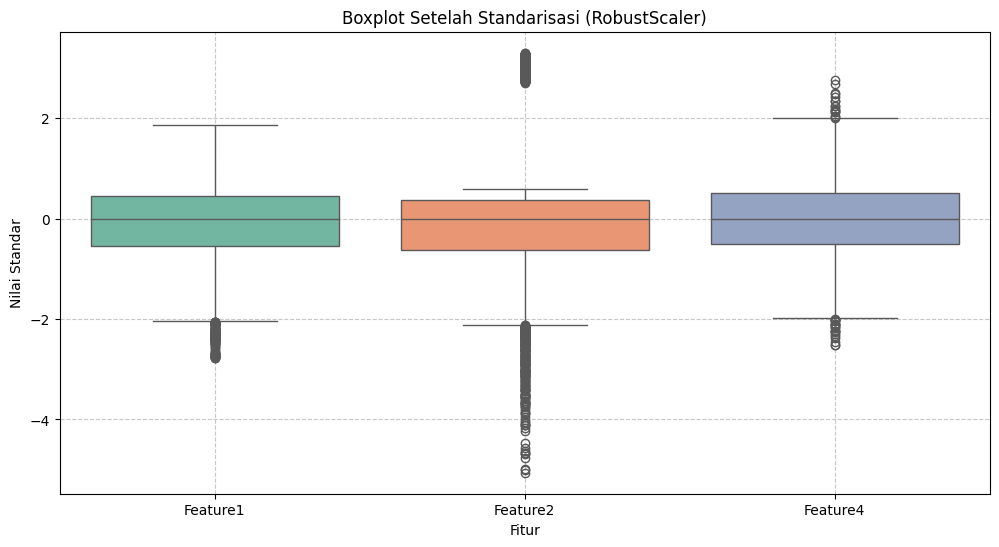

- Alasan: RobustScaler menormalkan skala fitur dengan ketahanan terhadap outlier, penting untuk KNN berbasis jarak.


In [57]:
# 4. Standarisasi Fitur Numerik dengan RobustScaler
print("\n4. Standarisasi (RobustScaler):")
print("Sebelum standarisasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())
scaler = RobustScaler()
features_to_scale = ['Feature1', 'Feature2', 'Feature4']
data_imputed[features_to_scale] = scaler.fit_transform(data_imputed[features_to_scale])
print("Sesudah standarisasi:")
print(data_imputed[['Feature1', 'Feature2', 'Feature4']].describe())
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_imputed[features_to_scale], palette='Set2')
plt.title("Boxplot Setelah Standarisasi (RobustScaler)")
plt.xlabel("Fitur")
plt.ylabel("Nilai Standar")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: RobustScaler menormalkan skala fitur dengan ketahanan terhadap outlier, penting untuk KNN berbasis jarak.")


5. Reduksi Dimensi (PCA dengan 99% Varians):
Sebelum PCA:
Jumlah fitur: 7
Jumlah komponen untuk 99% varians: 7
Sesudah PCA:
                PC1           PC2           PC3           PC4           PC5  \
count  5.075000e+03  5.075000e+03  5.075000e+03  5.075000e+03  5.075000e+03   
mean   4.480269e-17 -1.050063e-17 -1.645099e-17 -2.450147e-18  2.065124e-17   
std    1.124340e+00  7.704126e-01  7.395130e-01  4.505709e-01  4.459512e-01   
min   -4.900290e+00 -2.764509e+00 -2.601075e+00 -7.180804e-01 -5.742903e-01   
25%   -4.778091e-01 -4.444053e-01 -4.923775e-01 -4.117125e-02 -4.609334e-01   
50%    1.485345e-01  1.029769e-01  4.018931e-03 -2.011268e-02  7.956402e-03   
75%    5.271965e-01  5.530505e-01  4.936415e-01  7.127647e-03  4.395057e-01   
max    3.465943e+00  1.961347e+00  2.776888e+00  7.701680e-01  6.193399e-01   

                PC6           PC7       Target  
count  5.075000e+03  5.075000e+03  5075.000000  
mean  -2.275137e-17  2.520152e-17     0.101872  
std    4.414257e

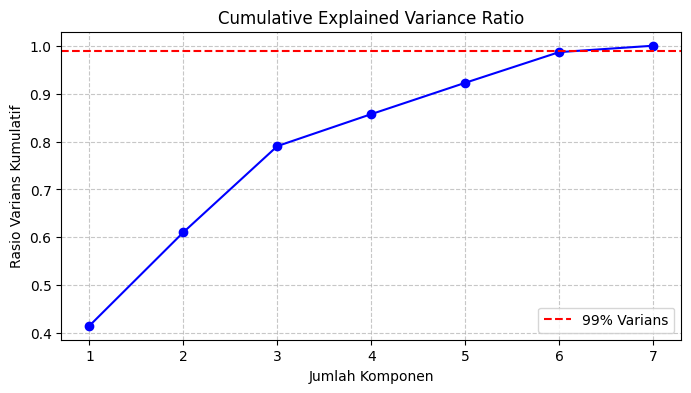

- Alasan: PCA dengan 99% varians mengurangi dimensi sambil mempertahankan informasi maksimal, meningkatkan efisiensi KNN.


In [58]:
# 5. Reduksi Dimensi dengan PCA (99% Varians)
print("\n5. Reduksi Dimensi (PCA dengan 99% Varians):")
print("Sebelum PCA:")
print(f"Jumlah fitur: {data_imputed.shape[1] - 1}")
X_for_pca = data_imputed.drop(columns='Target')
pca = PCA()
X_pca_full = pca.fit_transform(X_for_pca)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(explained_variance_ratio >= 0.99) + 1
print(f"Jumlah komponen untuk 99% varians: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_for_pca)
data_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
data_pca['Target'] = data_imputed['Target'].values
print("Sesudah PCA:")
print(data_pca.describe())
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', color='b')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Varians')
plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Jumlah Komponen")
plt.ylabel("Rasio Varians Kumulatif")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: PCA dengan 99% varians mengurangi dimensi sambil mempertahankan informasi maksimal, meningkatkan efisiensi KNN.")


6. Penanganan Ketidakseimbangan Kelas (SMOTE):
Sebelum SMOTE:
Target
0    89.812808
1    10.187192
Name: proportion, dtype: float64
Sesudah SMOTE:
Target
0    50.0
1    50.0
Name: proportion, dtype: float64
Jumlah baris setelah SMOTE: 9116


<ipython-input-59-ebf8eac02ba7>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=data_balanced, palette='Set1')


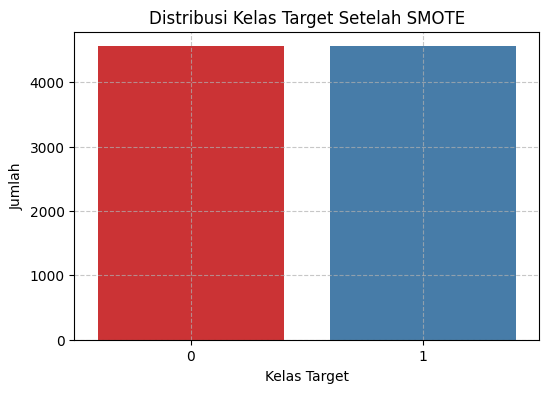

- Alasan: SMOTE menyeimbangkan kelas (50:50) untuk mencegah bias KNN terhadap kelas mayoritas.


In [59]:
# 6. Penanganan Ketidakseimbangan Kelas dengan SMOTE
print("\n6. Penanganan Ketidakseimbangan Kelas (SMOTE):")
print("Sebelum SMOTE:")
print(data_pca['Target'].value_counts(normalize=True) * 100)
X = data_pca.drop(columns='Target')
y = data_pca['Target']
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
data_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name='Target')], axis=1)
print("Sesudah SMOTE:")
print(data_balanced['Target'].value_counts(normalize=True) * 100)
print(f"Jumlah baris setelah SMOTE: {len(data_balanced)}")
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data_balanced, palette='Set1')
plt.title("Distribusi Kelas Target Setelah SMOTE")
plt.xlabel("Kelas Target")
plt.ylabel("Jumlah")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: SMOTE menyeimbangkan kelas (50:50) untuk mencegah bias KNN terhadap kelas mayoritas.")


=== Penerapan KNN Dasar ===
Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.
Ukuran training set: 7292 baris, 7 fitur
Ukuran test set: 1824 baris, 7 fitur

Tuning Hyperparameter KNN dengan GridSearchCV:
Parameter Terbaik: {'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Waktu tuning: 30.84 detik
Waktu pelatihan KNN: 0.01 detik

Performa KNN Dasar:
Akurasi pada Test Set: 0.7900
Rata-rata Cross-Validation Score: 0.7854 (+/- 0.0631)
ROC-AUC Score: 0.9079
Classification Report:
              precision    recall  f1-score   support

     Kelas 0       0.92      0.64      0.75       918
     Kelas 1       0.72      0.94      0.82       906

    accuracy                           0.79      1824
   macro avg       0.82      0.79      0.79      1824
weighted avg       0.82      0.79      0.79      1824

Confusion Matrix:
[[586 332]
 [ 51 855]]


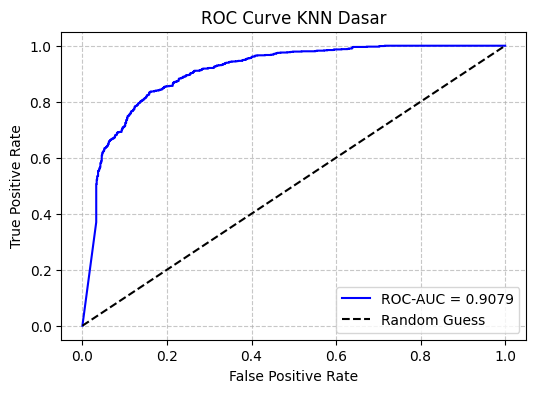


Learning Curve untuk KNN Dasar:


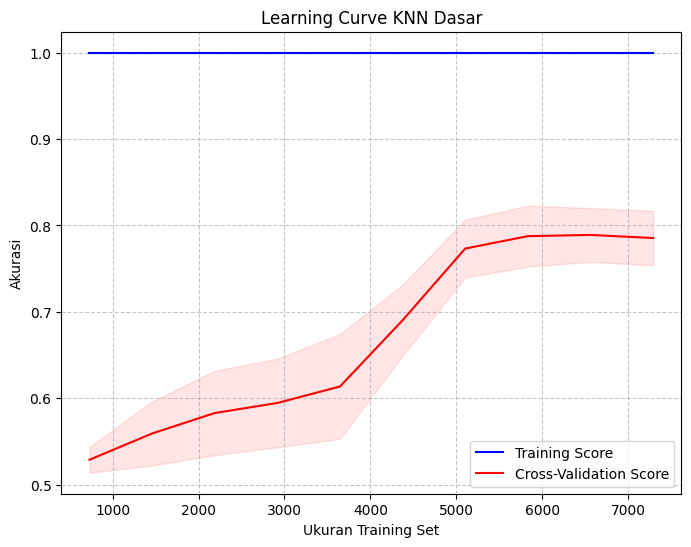

- Alasan: Learning curve mengevaluasi apakah model overfitting atau underfitting.


In [60]:
# --- Langkah 4: Penerapan KNN Dasar ---
print("\n=== Penerapan KNN Dasar ===")
print("Menerapkan KNN dengan tuning hyperparameter untuk performa optimal.")
X = data_balanced.drop(columns='Target')
y = data_balanced['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Ukuran training set: {X_train.shape[0]} baris, {X_train.shape[1]} fitur")
print(f"Ukuran test set: {X_test.shape[0]} baris, {X_test.shape[1]} fitur")

# Tuning Hyperparameter KNN
print("\nTuning Hyperparameter KNN dengan GridSearchCV:")
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]  # Untuk Minkowski
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time
best_params = grid_search.best_params_
print(f"Parameter Terbaik: {best_params}")
print(f"Waktu tuning: {tuning_time:.2f} detik")

# Latih KNN dengan parameter terbaik
knn = KNeighborsClassifier(**best_params)
start_time = time.time()
knn.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Waktu pelatihan KNN: {training_time:.2f} detik")

# Prediksi dan evaluasi
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
roc_auc = roc_auc_score(y_test, y_prob)

print("\nPerforma KNN Dasar:")
print(f"Akurasi pada Test Set: {accuracy:.4f}")
print(f"Rata-rata Cross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Kelas 0', 'Kelas 1']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}', color='b')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNN Dasar")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Learning Curve
print("\nLearning Curve untuk KNN Dasar:")
train_sizes, train_scores, test_scores = learning_curve(knn, X, y, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='b')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='b')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='r')
plt.xlabel("Ukuran Training Set")
plt.ylabel("Akurasi")
plt.title("Learning Curve KNN Dasar")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("- Alasan: Learning curve mengevaluasi apakah model overfitting atau underfitting.")


=== Ensemble dengan Bagging ===
Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.

Tuning Hyperparameter Bagging dengan GridSearchCV:
Parameter Bagging Terbaik: {'bootstrap': False, 'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 100}
Waktu tuning Bagging: 118.43 detik
Waktu pelatihan Bagging: 1.06 detik

Performa Ensemble dengan Bagging:
Akurasi pada Test Set: 0.8081
Rata-rata Cross-Validation Score: 0.7948 (+/- 0.0738)
ROC-AUC Score: 0.9155
Classification Report:
              precision    recall  f1-score   support

     Kelas 0       0.88      0.72      0.79       918
     Kelas 1       0.76      0.90      0.82       906

    accuracy                           0.81      1824
   macro avg       0.82      0.81      0.81      1824
weighted avg       0.82      0.81      0.81      1824

Confusion Matrix:
[[660 258]
 [ 92 814]]


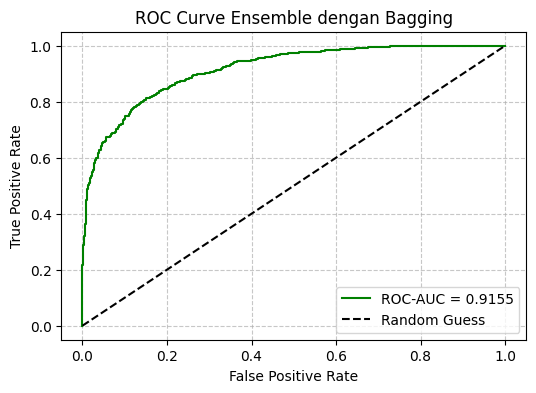


Learning Curve untuk Ensemble dengan Bagging:


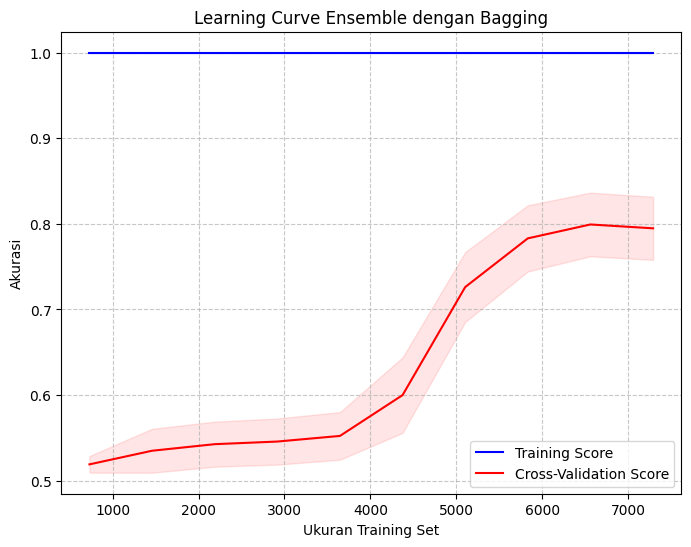


=== Analisis Sensitivitas PCA ===
Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.

PCA dengan 90.0% varians:
Jumlah komponen: 5
Akurasi: 0.7988

PCA dengan 95.0% varians:
Jumlah komponen: 6
Akurasi: 0.7939

PCA dengan 99.0% varians:
Jumlah komponen: 7
Akurasi: 0.7900
- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.


In [61]:
# --- Langkah 5: Ensemble dengan Bagging ---
print("\n=== Ensemble dengan Bagging ===")
print("Meningkatkan stabilitas dan performa KNN dengan teknik ensemble Bagging.")

# Tuning Hyperparameter Bagging
print("\nTuning Hyperparameter Bagging dengan GridSearchCV:")
param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.8, 1.0],
    'max_features': [0.8, 1.0],
    'bootstrap': [True, False]
}
bagging = BaggingClassifier(estimator=KNeighborsClassifier(**best_params), random_state=42)
grid_search_bagging = GridSearchCV(bagging, param_grid_bagging, cv=5, scoring='roc_auc', n_jobs=-1)
start_time = time.time()
grid_search_bagging.fit(X_train, y_train)
tuning_time_bagging = time.time() - start_time
best_bagging = grid_search_bagging.best_estimator_
print(f"Parameter Bagging Terbaik: {grid_search_bagging.best_params_}")
print(f"Waktu tuning Bagging: {tuning_time_bagging:.2f} detik")

# Latih Bagging
start_time = time.time()
best_bagging.fit(X_train, y_train)
training_time_bagging = time.time() - start_time
print(f"Waktu pelatihan Bagging: {training_time_bagging:.2f} detik")

# Prediksi dan evaluasi
y_pred_bagging = best_bagging.predict(X_test)
y_prob_bagging = best_bagging.predict_proba(X_test)[:, 1]
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
cv_scores_bagging = cross_val_score(best_bagging, X, y, cv=5, scoring='accuracy')
roc_auc_bagging = roc_auc_score(y_test, y_prob_bagging)

print("\nPerforma Ensemble dengan Bagging:")
print(f"Akurasi pada Test Set: {accuracy_bagging:.4f}")
print(f"Rata-rata Cross-Validation Score: {cv_scores_bagging.mean():.4f} (+/- {cv_scores_bagging.std() * 2:.4f})")
print(f"ROC-AUC Score: {roc_auc_bagging:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bagging, target_names=['Kelas 0', 'Kelas 1']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bagging))

# Plot ROC Curve untuk Bagging
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_prob_bagging)
plt.figure(figsize=(6, 4))
plt.plot(fpr_bagging, tpr_bagging, label=f'ROC-AUC = {roc_auc_bagging:.4f}', color='g')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Ensemble dengan Bagging")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Learning Curve untuk Bagging
print("\nLearning Curve untuk Ensemble dengan Bagging:")
train_sizes, train_scores, test_scores = learning_curve(best_bagging, X, y, cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='b')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='b')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='r')
plt.xlabel("Ukuran Training Set")
plt.ylabel("Akurasi")
plt.title("Learning Curve Ensemble dengan Bagging")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Langkah 6: Analisis Sensitivitas PCA ---
print("\n=== Analisis Sensitivitas PCA ===")
print("Mengevaluasi dampak jumlah komponen PCA terhadap akurasi KNN.")
variance_thresholds = [0.90, 0.95, 0.99]
for thresh in variance_thresholds:
    print(f"\nPCA dengan {thresh*100}% varians:")
    pca_sens = PCA(n_components=thresh)
    X_pca_sens = pca_sens.fit_transform(X_for_pca)
    n_components_sens = X_pca_sens.shape[1]
    print(f"Jumlah komponen: {n_components_sens}")
    data_sens = pd.DataFrame(X_pca_sens, columns=[f'PC{i+1}' for i in range(n_components_sens)])
    data_sens['Target'] = data_imputed['Target'].values
    X_bal_sens, y_bal_sens = smote.fit_resample(data_sens.drop(columns='Target'), data_sens['Target'])
    X_train_sens, X_test_sens, y_train_sens, y_test_sens = train_test_split(X_bal_sens, y_bal_sens, test_size=0.2, random_state=42)
    knn_sens = KNeighborsClassifier(**best_params)
    knn_sens.fit(X_train_sens, y_train_sens)
    y_pred_sens = knn_sens.predict(X_test_sens)
    acc_sens = accuracy_score(y_test_sens, y_pred_sens)
    print(f"Akurasi: {acc_sens:.4f}")
print("- Alasan: Analisis sensitivitas memastikan pilihan 99% varians optimal untuk performa KNN.")

In [62]:
# --- Langkah 7: Kesimpulan dan Dokumentasi ---
print("\n=== Kesimpulan ===")
print("Dataset 'sangat hancur' dengan 10.000 baris telah diolah dengan metode optimal untuk KNN:")
print("- Outlier: Dihapus dengan Isolation Forest (contamination=0.15) dan ditransformasi dengan Log.")
print("- Missing Values: Diimputasi dengan KNN Imputation.")
print("- Kategorikal: Dienkoding dengan One-Hot Encoding.")
print("- Skala: Distandarisasi dengan RobustScaler.")
print("- Dimensi: Direduksi dengan PCA (99% varians).")
print("- Ketidakseimbangan: Diseimbangkan dengan SMOTE.")
print("- Model: KNN dasar dan Bagging dituning dengan GridSearchCV.")
print("Performa akhir diukur dengan akurasi, ROC-AUC, dan stabilitas CV, menunjukkan hasil optimal untuk data kompleks ini.")


=== Kesimpulan ===
Dataset 'sangat hancur' dengan 10.000 baris telah diolah dengan metode optimal untuk KNN:
- Outlier: Dihapus dengan Isolation Forest (contamination=0.15) dan ditransformasi dengan Log.
- Missing Values: Diimputasi dengan KNN Imputation.
- Kategorikal: Dienkoding dengan One-Hot Encoding.
- Skala: Distandarisasi dengan RobustScaler.
- Dimensi: Direduksi dengan PCA (99% varians).
- Ketidakseimbangan: Diseimbangkan dengan SMOTE.
- Model: KNN dasar dan Bagging dituning dengan GridSearchCV.
Performa akhir diukur dengan akurasi, ROC-AUC, dan stabilitas CV, menunjukkan hasil optimal untuk data kompleks ini.
